In [1]:
# 1. load CapgMyo dataset
# 2. normalization, convert to a grayscale image with a linear transform
# 3. output as Nonex8x16x3 sequence as the baseline dataset
# 6. TODO: add low-pass filtered: full wave rectified and low-pass filtered using 

In [6]:
import numpy as np
from scipy.io import loadmat
import os
import re
import h5py

In [3]:
def convert_emg(mat_file, image_size = (8, 16)):
    emg_array = np.array(mat_file['data'])
    # convert data from [-2.5, 2.5]  to [0, 1]
    scale = 10000
    emg_array = (emg_array * scale + 2.5*scale) / (5*scale)
    
    frames_size = (emg_array.shape[0], image_size[0], image_size[1], 3)
    emg_frames = np.empty(frames_size)
    for i in range(emg_array.shape[0]):
        frame = np.reshape(emg_array[i], image_size)
        # replicate three times as RGB channel
        frame_3d = frame[:,:,None] * np.ones(3, dtype=int)[None,None,:]
        emg_frames[i] = frame_3d
    return emg_frames

In [4]:
# read all mat files into a dict<gestures id:gestures list>
def process_row_data(db_name):
    DB_NAME = db_name
    INPUT_DIR = '../data/capg_raw/'
    gestures = dict()
    for root, directories, files in os.walk(INPUT_DIR):
        if not re.search(DB_NAME, root):
            continue
        print('root:{}, directories:{}, files: {}'.format(root, len(directories), len(files)))
        for file in files:
            gesture_num = file[4:7]
            if gesture_num not in gestures.keys():
                gestures[gesture_num] = list()
            file_loc = os.path.join(root, file)
            mat = loadmat(file_loc)
            gestures[gesture_num].append(convert_emg(mat))

    print(gestures.keys())

    return gestures

In [5]:
dba_gestures = process_row_data('dba-')

root:../data/capg_raw/dba-preprocessed-011, directories:0, files: 82
root:../data/capg_raw/dba-preprocessed-016, directories:0, files: 82
root:../data/capg_raw/dba-preprocessed-018, directories:0, files: 82
root:../data/capg_raw/dba-preprocessed-017, directories:0, files: 82


KeyboardInterrupt: 

In [ ]:
dbb_gestures = process_row_data('dbb-')

In [ ]:
dbc_gestures = process_row_data('dbc-')

In [ ]:
# output data, store in h5 files
# name format: [abc]+-gesture number.h5
merged_gestures = dict()
for gesture_num in dbc_gestures.keys():
    if gesture_num in ['101', '100']:
        new_num = 'abc-' + gesture_num
        merged_gestures[new_num] = dba_gestures[gesture_num]\
                                  +dbb_gestures[gesture_num]\
                                  +dbc_gestures[gesture_num]
        continue
    elif gesture_num not in ['009', '010', '011', '012']:
        new_num = 'ab-' + gesture_num
        merged_gestures[new_num] = dba_gestures[gesture_num] + dbb_gestures[gesture_num]
   
    new_num = 'c-' + gesture_num
    merged_gestures[new_num] = dbc_gestures[gesture_num]

print(merged_gestures.keys())
print(len(merged_gestures.keys()))

In [ ]:
OUTPUT_DIR = '../data/capg_baseline/'
for key, gesture in merged_gestures.items():
    gesture_frames = np.empty((len(gesture), 1000, 8, 16, 3))
    for i in range(len(gesture)):
        gesture_frames[i] = gesture[i]
    output_file = key + '.h5'
    out_loc = os.path.join(OUTPUT_DIR, output_file)
    print('FILE:{}, SAMPLE AMOUNT:{}'.format(output_file, gesture_frames.shape[0]))
    h5f = h5py.File(out_loc, 'w')
    h5f.create_dataset(output_file, data=gesture_frames)

h5f.close()

In [7]:
import matplotlib.pyplot as plt

mat = loadmat('../data/capg_raw/dba-preprocessed-001/001-001-001.mat')
emg_array = np.array(mat['data'])
scale = 10000
emg_array = (emg_array * scale + 2.5*scale) / (5*scale)
frame = np.reshape(emg_array[0,:], (8, 16))
plt.imshow(frame, cmap=plt.cm.gray_r)
# TODO: how to smooth the image?
# if the cnn can detect the fluctuation of single pixel?
# TODO: try different filters or use LSTM directly

(8, 16, 3)


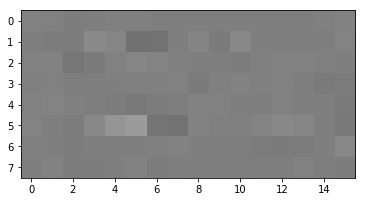

In [8]:
# replicate three times as RGB channel
frame_3d = frame[:,:,None] * np.ones(3, dtype=int)[None,None,:]
print(frame_3d.shape)
plt.imshow(frame_3d, cmap=plt.cm.gray_r)

In [20]:
# 可视化1000行数据
plt.figure(figsize=(300,50))
mat = loadmat('../data/capg_raw/dba-preprocessed-001/001-001-001.mat')
emg_array = np.array(mat['data'])
scale = 10000
emg_array = (emg_array * scale + 2.5*scale) / (5*scale)
# plt.imshow(emg_array)#, cmap=plt.cm.gray_r)

<Figure size 21600x3600 with 0 Axes>